In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import deepjets as dj
import seaborn

In [ ]:
model = dj.models.get_maxout(25**2)

In [ ]:
n_images = -1
n_folds = 1
test_frac = 0.1
val_frac = 0.1
sig_file = 'images/w_images.h5'
bkd_file = 'images/qcd_images.h5'
dataset_name = 'datasets/test'
model_name = 'models/test'

In [ ]:
h5_files = dj.utils.prepare_datasets(
    sig_file, bkd_file, dataset_name, n_sig=n_images, n_bkd=n_images, test_frac=test_frac,
    val_frac=val_frac, n_folds=n_folds, auxvars=['weights'], shuffle=True, shuffle_seed=1)

In [ ]:
dj.learning.train_model(model, h5_files['train'], model_name)

Testing on 200000 samples.
Dataset from datasets/w_big_test.h5.
Score    = 0.40581764462
AUC      = 53.7996114791
Accuracy = 166528/200000 = 0.83264



//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:462: UserWarning: The handle <matplotlib.lines.Line2D object at 0x11122c790> has a label of u'_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
//anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


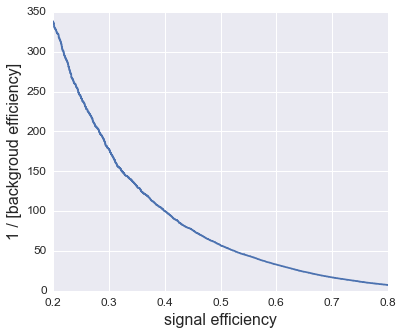

In [14]:
roc = dj.learning.test_model(dj.models.load_model('models/maxout_w_default'),
                             'datasets/w_big_test.h5')

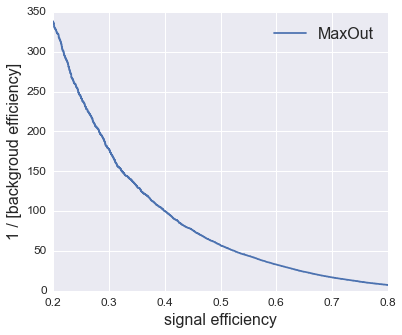

In [15]:
dj.utils.plot_roc_curve(roc['ROC_curve'], 'MaxOut')